In [2]:
import matplotlib.pyplot as plt
import shapely.geometry as geom
import shapely.affinity as transform

In [3]:
def plot_coords(coords):
    x,y = zip(*list(coords))
    plt.plot(x,y)

def plot_points(points):
    x,y = zip(*list(points))
    plt.scatter(x, y)

def plot_polys(polys):
    for poly in polys:
        if (not getattr(poly, "exterior", None)):
            print("got line?")

        plot_coords(poly.exterior.coords)

        for hole in poly.interiors:
            plot_coords(hole.coords)

# def plot_multi(coords, polys, )

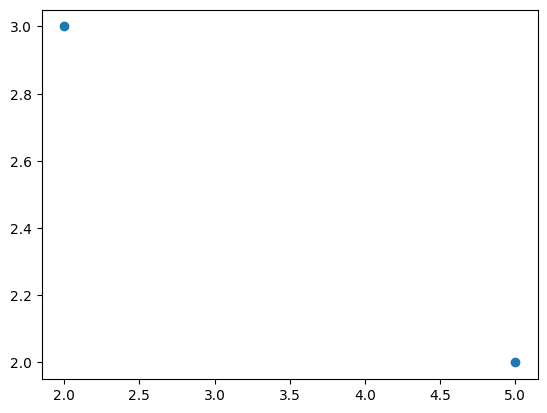

In [4]:
a = geom.Polygon([(5, 6), (4, 7), (2, 6)])
b = geom.Polygon([(1, 1), (2, 4), (5, 3), (1, 3)])

plot_points([(2, 3), (5, 2)])
plt.axis
plt.show()